# Neural Network for Predicting the Lorenz System
## point(d)

In 1963, Edward Lorenz, with the help of Ellen Fetter who was responsible for the numerical simulations and figures, and Margaret Hamilton who helped in the initial, numerical computations leading up to the findings of the Lorenz model, developed a simplified mathematical model for atmospheric convection. The model is a system of three ordinary differential equations now known as the Lorenz equations:

$$ \frac{\partial x}{\partial t} = \sigma (y-x) $$
$$ \frac{\partial y}{\partial t} = x ( \rho - z ) - y $$
$$ \frac{\partial z}{\partial t} = xy - \beta z $$

The equations relate the properties of a two-dimensional fluid layer uniformly warmed from below and cooled from above. In particular, the equations describe the rate of change of three quantities with respect to time: 

- $x$ is proportional to the rate of convection.
- $y$ is proportional to the horizontal temperature variation.
- $z$ is proportional to the vertical temperature variation.

The constants $\sigma$, $\rho$, and $\beta$ are system parameters proportional to the Prandtl number, Rayleigh number, and certain physical dimensions of the layer itself.

In [1]:
# Import the necessary libraries.
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  

import numpy as np
from scipy.integrate import odeint
import tensorflow as tf


# Import plotting libraries and tools.
%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

Here we setup the problem:
- ```x0``` : is the vector with the starting conditions.
- ```t``` : it the vector defining the time-steps where the integration is performed.
- ```sigma``` , ```rho``` , ```beta``` : are the parameters of the Lorenz system.

In [2]:
# Initial conditions.
x0 = [ 10.0 , 0.5 , 1.0 ]

# Time-steps interval.
t = np.arange( 0 , 50 , 0.01 )

# Problem parameters.
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0

The RHS of the Lorenz Equations is defined, and used to feed the ```odinet``` algorithm, together with the inittal conditions, the time-step vector and the parameters.

In [3]:
# Define the Lorenz system.
def RHSLorenz( x , t , sigma , rho , beta ):
    x_dot = sigma * (x[1] - x[0])
    y_dot = x[0] * (rho - x[2]) - x[1]
    z_dot = x[0] * x[1] - beta * x[2]
    return [x_dot, y_dot, z_dot]

Lorenz_sol = odeint( RHSLorenz , x0 , t , args = ( sigma , rho , beta ) )
Lorenz_sol = Lorenz_sol.T

A Tensorfloe model is created, which takes as input $(x_t,y_t,z_t)$ and gives as output $(x_{t+1},y_{t+1},z_{t+1})$, as usual the steps are:
1) Define the training dataset in terms of input and output.
2) Define a model with Tensorflow (in this case we used a simple FFNN).
3) Compile the model with a loss function and an optimizer.
4) Train the model over several epochs.
5) Use the trained model to make predictions.
6) Plot the predictions.

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

# Define the network input and output.
IN = Lorenz_sol[ : , 0 : -1 ].T
OUT = Lorenz_sol[ : , 1 : ].T

# Define the hidden units, input and output dimensions.
hidden_size = 10
num_inputs = 3
num_outputs = 3

# Create a sequential model.
model = Sequential()
model.add(Input(shape=(num_inputs,)))
model.add(Dense(hidden_size, activation='tanh'))
model.add(Dense(hidden_size, activation='tanh'))
model.add(Dense(num_outputs, activation='linear'))

# Compile the model.
model.compile( loss = 'mse', optimizer = 'adam')

# Fit the model.
callback = EarlyStopping( monitor = 'loss' , patience = 20 , min_delta = 1e-7 )
H = model.fit( IN , OUT , epochs = 500 , batch_size = 200 , shuffle = True , callbacks=[callback] , verbose = 0 )  

# Predict.
PREDICTIONS = model.predict( IN , verbose = 0 )

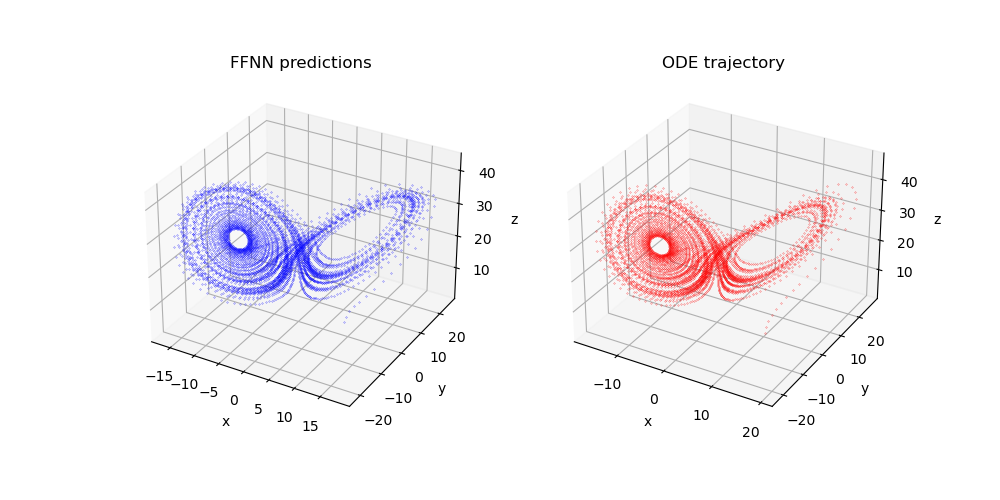

In [5]:
fig = plt.figure(figsize = ( 10 , 5 ) )
ax1 = fig.add_subplot( 121 , projection = '3d' )
ax2 = fig.add_subplot( 122 , projection = '3d' )
ax1.plot( PREDICTIONS[ : , 0 ] , PREDICTIONS[ : , 1 ] , PREDICTIONS[ : , 2 ] , '.' , markersize = 0.4 , color = "blue" )
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.set_title('FFNN predictions')

ax2.plot( Lorenz_sol[0] , Lorenz_sol[1] , Lorenz_sol[2] , '.' , markersize = 0.4 , color = "red" )
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
ax2.set_title('ODE trajectory')
plt.show()

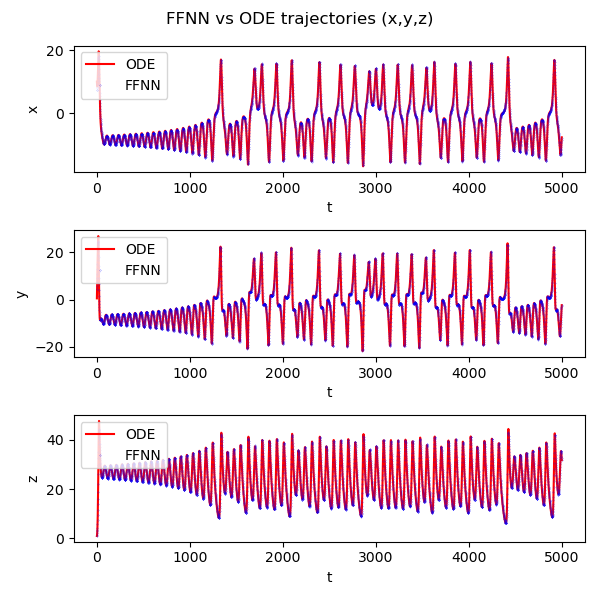

In [6]:
fig.clear()
plt.close()

fig = plt.figure(figsize = ( 6 , 6 ) )
ax1 = fig.add_subplot( 311 )
ax2 = fig.add_subplot( 312 )
ax3 = fig.add_subplot( 313 )

for ax , i , coord in zip( [ ax1 , ax2 , ax3 ] , [ 0 , 1 , 2 ] , [ "x" , "y" , "z" ] ):

    ax.plot( Lorenz_sol[i] , color = "red" , label = "ODE" )
    ax.plot( PREDICTIONS[ : , i ] , "." , color = "blue" , markersize = "0.3" , label = "FFNN" )
    ax.set_xlabel("t")
    ax.set_ylabel(coord)
    ax.legend( loc = 'upper left' )
    
plt.suptitle("FFNN vs ODE trajectories (x,y,z)")
plt.tight_layout()   
plt.show()

## point (e)

In this exercise we should train our NN to identify when a transition from one lobe to another is imminent and determine how far in advance we can make this prediction.  

Note: it is necessary to label the transitions in a test set in order to do this task.

The following plot shows that a very simple way to distinguish the two lobes is to implement the inequalities: $x<0$ or $x>0$.

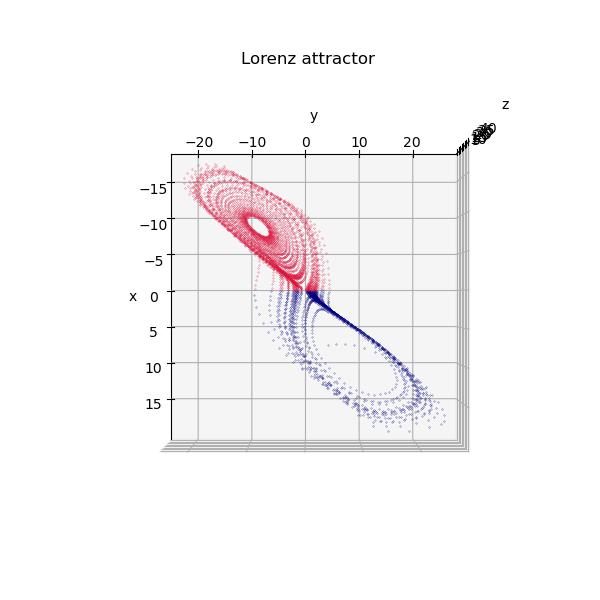

In [7]:
# Assign colors to the line segments
PRED_xsup = PREDICTIONS[ PREDICTIONS[ : , 0 ] > 0 ]
PRED_xmin = PREDICTIONS[ PREDICTIONS[ : , 0 ] < 0 ]

fig = plt.figure( figsize = ( 6 , 6 ) )
ax = fig.add_subplot( 111 , projection = '3d' )
ax.plot( PRED_xsup[ : , 0 ] , PRED_xsup[ : , 1 ] , PRED_xsup[ : , 2 ] , '.' , markersize = 0.4 , color = "navy" , lw = 0.5)
ax.plot( PRED_xmin[ : , 0 ] , PRED_xmin[ : , 1 ] , PRED_xmin[ : , 2 ] , '.' , markersize = 0.4 , color = "crimson" , lw = 0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init( 90 , 0 )
ax.set_title('Lorenz attractor')
plt.show()